# Improving Retrieval systems by diversifying the results using Pyversity
Pyversity is a fast, lightweight Python library designed to improve the diversity of results from retrieval systems. Retrieval often returns items that are very similar, leading to redundancy. Pyversity efficiently re-ranks these results to surface relevant but less redundant items.

It offers a clear, unified API for several popular diversification strategies, including Maximal Marginal Relevance (MMR), Max-Sum-Diversification (MSD), Determinantal Point Processes (DPP), and Cover. Its only dependency is NumPy, making it very lightweight.

In this tutorial, we'll focus on the MMR and MSD strategies using a practical example.


## Installing the dependencies

In [1]:
!pip install openai numpy pyversity scikit-learn

### Loading OpenAI API Key

In [2]:
import os
from openai import OpenAI
from getpass import getpass
os.environ['OPENAI_API_KEY'] = getpass('Enter OpenAI API Key: ')

client = OpenAI()

Enter OpenAI API Key: ··········


## Creating a Redundant Search Result Set for Diversification Testing
In this step, we’re simulating the kind of search results you might retrieve from a vector database (like Pinecone, Weaviate, or FAISS) after performing a semantic search for a query such as “Smart and loyal dogs for family.”

These results intentionally contain redundant entries — multiple mentions of similar breeds like Golden Retrievers, Labradors, and German Shepherds — each described with overlapping traits such as loyalty, intelligence, and family-friendliness.

This redundancy mirrors what often happens in real-world retrieval systems, where highly similar items receive high similarity scores. We’ll use this dataset to demonstrate how diversification techniques (MMR, MSD, DPP, and COVER) can reduce repetition and produce a more balanced, diverse set of search results.

In [40]:
import numpy as np

search_results = [
    "The Golden Retriever is the perfect family companion, known for its loyalty and gentle nature.",
    "A Labrador Retriever is highly intelligent, eager to please, and makes an excellent companion for active families.",
    "Golden Retrievers are highly intelligent and trainable, making them ideal for first-time owners.",
    "The highly loyal Labrador is consistently ranked number one for US family pets due to its stable temperament.",
    "Loyalty and patience define the Golden Retriever, one of the top family dogs globally and easily trainable.",
    "For a smart, stable, and affectionate family dog, the Labrador is an excellent choice, known for its eagerness to please.",
    "German Shepherds are famous for their unwavering loyalty and are highly intelligent working dogs, excelling in obedience.",
    "A highly trainable and loyal companion, the German Shepherd excels in family protection roles and service work.",
    "The Standard Poodle is an exceptionally smart, athletic, and surprisingly loyal dog that is also hypoallergenic.",
    "Poodles are known for their high intelligence, often exceeding other breeds in advanced obedience training.",
    "For herding and smarts, the Border Collie is the top choice, recognized as the world's most intelligent dog breed.",
    "The Dachshund is a small, playful dog with a distinctive long body, originally bred in Germany for badger hunting.",
    "French Bulldogs are small, low-energy city dogs, known for their easy-going temperament and comical bat ears.",
    "Siberian Huskies are energetic, friendly, and need significant cold weather exercise due to their running history.",
    "The Beagle is a gentle, curious hound known for its excellent sense of smell and a distinctive baying bark.",
    "The Great Dane is a very large, gentle giant breed; despite its size, it's known to be a low-energy house dog.",
    "The Australian Shepherd (Aussie) is a medium-sized herding dog, prized for its beautiful coat and sharp intellect."
]

## Creating the Embeddings

In [41]:
def get_embeddings(texts):
    """Fetches embeddings from the OpenAI API."""
    print("Fetching embeddings from OpenAI...")
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=texts
    )
    return np.array([data.embedding for data in response.data])

In [42]:
embeddings = get_embeddings(search_results)
print(f"Embeddings shape: {embeddings.shape}")

Fetching embeddings from OpenAI...
Embeddings shape: (17, 1536)


## Ranking Search Results by Relevance
In this step, we calculate how closely each search result matches the user’s query using cosine similarity between their vector embeddings. This produces a ranked list of results purely based on semantic relevance, showing which texts are most similar in meaning to the query. Essentially, it simulates what a search engine or retrieval system would return before applying any diversification techniques, often resulting in several highly similar or redundant entries at the top.

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

query_text = "Smart and loyal dogs for family"
query_embedding = get_embeddings([query_text])[0]


scores = cosine_similarity(query_embedding.reshape(1, -1), embeddings)[0]

print("\n--- Initial Relevance-Only Ranking (Top 5) ---")
initial_ranking_indices = np.argsort(scores)[::-1] # Sort descending
for i in initial_ranking_indices[:5]:
    print(f"Score: {scores[i]:.4f} | Result: {search_results[i]}")


Fetching embeddings from OpenAI...

--- Initial Relevance-Only Ranking (Top 5) ---
Score: 0.6203 | Result: For a smart, stable, and affectionate family dog, the Labrador is an excellent choice, known for its eagerness to please.
Score: 0.5705 | Result: A Labrador Retriever is highly intelligent, eager to please, and makes an excellent companion for active families.
Score: 0.5698 | Result: Loyalty and patience define the Golden Retriever, one of the top family dogs globally and easily trainable.
Score: 0.5564 | Result: The highly loyal Labrador is consistently ranked number one for US family pets due to its stable temperament.
Score: 0.5437 | Result: German Shepherds are famous for their unwavering loyalty and are highly intelligent working dogs, excelling in obedience.


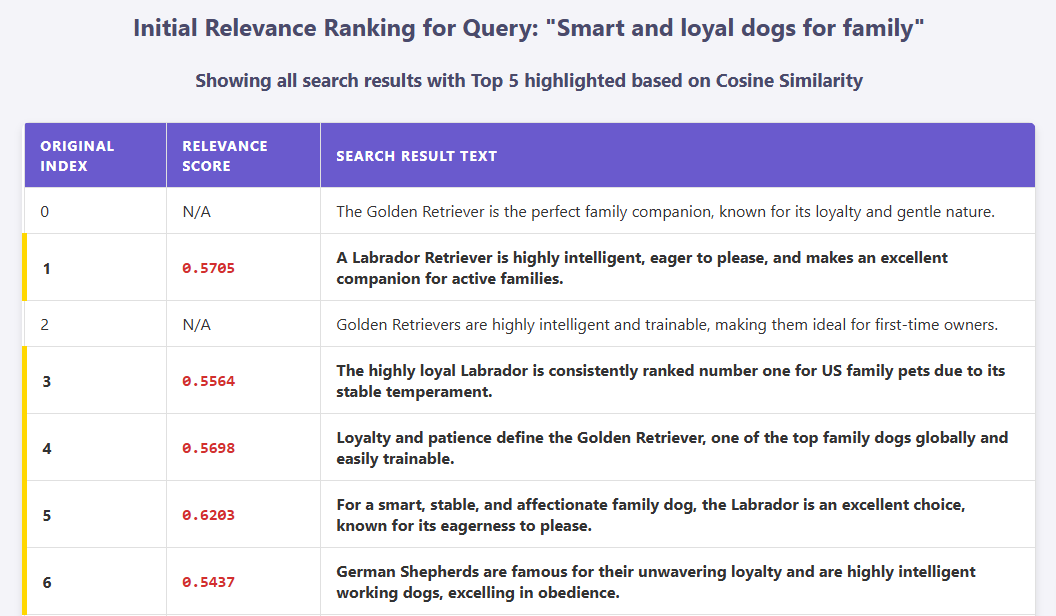

As seen in the output above, the top results are dominated by multiple mentions of Labradors and Golden Retrievers, each described with similar traits like loyalty, intelligence, and family-friendliness. This is typical of a relevance-only retrieval system, where the top results are semantically similar but often redundant, offering little diversity in content. While these results are all relevant to the query, they lack variety — making them less useful for users who want a broader overview of different breeds or perspectives.

## Maximal Marginal Relevance
MMR works by finding a balance between relevance and diversity. Instead of simply picking the most similar results to the query, it gradually selects items that are still relevant but not too similar to what’s already been chosen.

In simpler terms, imagine you’re building a list of dog breeds for “smart and loyal family dogs.” The first result might be a Labrador — highly relevant. For the next choice, MMR avoids picking another Labrador description and instead selects something like a Golden Retriever or German Shepherd.

This way, MMR ensures your final results are both useful and varied, reducing repetition while keeping everything closely related to what the user actually searched for.

In [44]:
from pyversity import diversify, Strategy

# MMR: Focuses on novelty against already picked items.
mmr_result = diversify(
    embeddings=embeddings,
    scores=scores,
    k=5,
    strategy=Strategy.MMR,
    diversity=0.5  # 0.0 is pure relevance, 1.0 is pure diversity
)

print("\n\n--- Diversified Ranking using MMR (Top 5) ---")
for rank, idx in enumerate(mmr_result.indices):
    print(f"Rank {rank+1} (Original Index {idx}): {search_results[idx]}")



--- Diversified Ranking using MMR (Top 5) ---
Rank 1 (Original Index 5): For a smart, stable, and affectionate family dog, the Labrador is an excellent choice, known for its eagerness to please.
Rank 2 (Original Index 6): German Shepherds are famous for their unwavering loyalty and are highly intelligent working dogs, excelling in obedience.
Rank 3 (Original Index 13): Siberian Huskies are energetic, friendly, and need significant cold weather exercise due to their running history.
Rank 4 (Original Index 12): French Bulldogs are small, low-energy city dogs, known for their easy-going temperament and comical bat ears.
Rank 5 (Original Index 2): Golden Retrievers are highly intelligent and trainable, making them ideal for first-time owners.


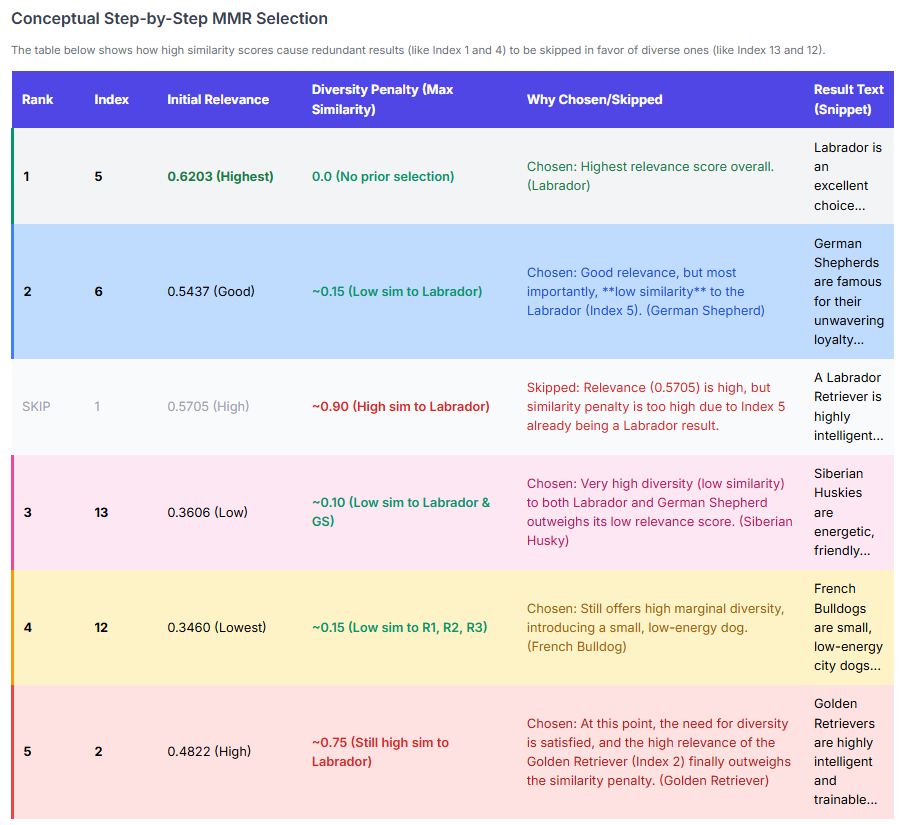

After applying the MMR (Maximal Marginal Relevance) strategy, the results are noticeably more diverse. While the top-ranked items like the Labrador and German Shepherd remain highly relevant to the query, the subsequent entries include different breeds such as Siberian Huskies and French Bulldogs. This shows how MMR reduces redundancy by avoiding multiple similar results — instead, it balances relevance and variety, giving users a broader and more informative set of results that still stay on topic.

## Max Sum of Distances
The MSD (Max Sum of Distances) strategy focuses on selecting results that are not only relevant to the query but also as different from each other as possible. Instead of worrying about similarity to previously picked items one by one (like MMR does), MSD looks at the overall spread of the selected results.

In simpler terms, it tries to pick results that cover a wider range of ideas or topics, ensuring strong diversity across the entire set. So, for the same dog example, MSD might include breeds like Labrador, German Shepherd, Beagle, and Husky — each distinct in type and temperament — to give a broader, well-rounded view of “smart and loyal family dogs.”

In [45]:
# MSD: Focuses on strong spread/distance across all candidates.
msd_result = diversify(
    embeddings=embeddings,
    scores=scores,
    k=5,
    strategy=Strategy.MSD,
    diversity=0.5
)

print("\n\n--- Diversified Ranking using MSD (Top 5) ---")
for rank, idx in enumerate(msd_result.indices):
    print(f"Rank {rank+1} (Original Index {idx}): {search_results[idx]}")



--- Diversified Ranking using MSD (Top 5) ---
Rank 1 (Original Index 5): For a smart, stable, and affectionate family dog, the Labrador is an excellent choice, known for its eagerness to please.
Rank 2 (Original Index 6): German Shepherds are famous for their unwavering loyalty and are highly intelligent working dogs, excelling in obedience.
Rank 3 (Original Index 12): French Bulldogs are small, low-energy city dogs, known for their easy-going temperament and comical bat ears.
Rank 4 (Original Index 13): Siberian Huskies are energetic, friendly, and need significant cold weather exercise due to their running history.
Rank 5 (Original Index 11): The Dachshund is a small, playful dog with a distinctive long body, originally bred in Germany for badger hunting.


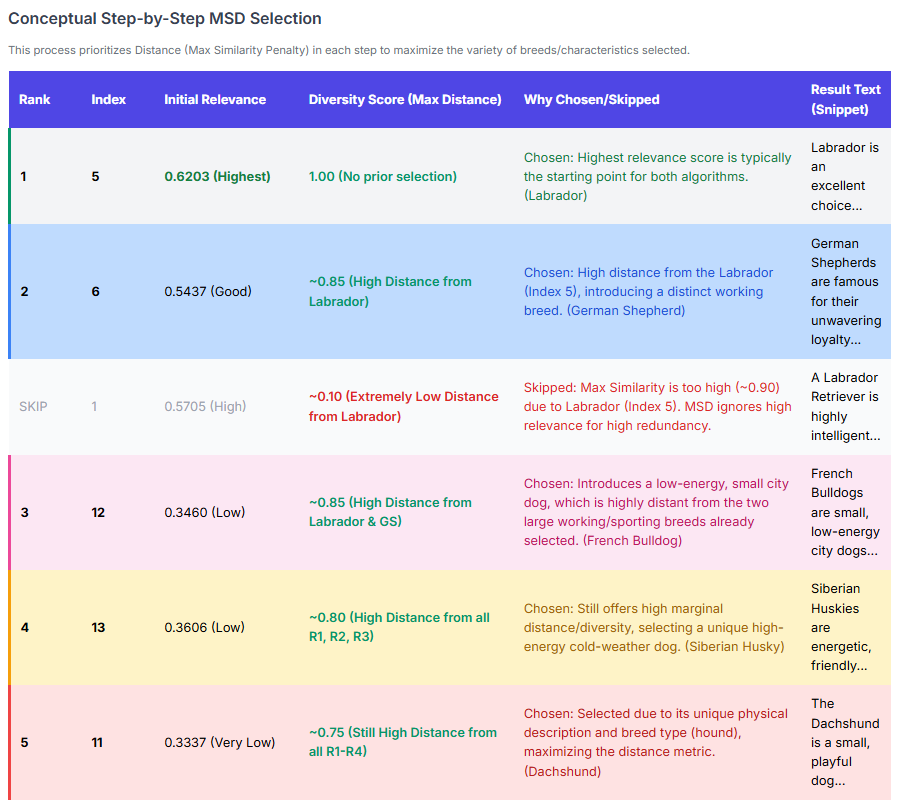

The results produced by the MSD (Max Sum of Distances) strategy show a strong focus on variety and coverage. While the Labrador and German Shepherd remain relevant to the query, the inclusion of breeds like the French Bulldog, Siberian Husky, and Dachshund highlights MSD’s tendency to select results that are distinct from one another.

This approach ensures that users see a broader mix of options rather than closely related or repetitive entries. In essence, MSD emphasizes maximum diversity across the entire result set, offering a wider perspective while still maintaining overall relevance to the search intent.